In [1]:
import finesse
from finesse.gaussian import BeamParam
from finesse.knm import Map
from finesse.gaussian import optimise_HG00_q_scipy, optimise_HG00_q

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
import scipy.integrate as integrate
from sympy import symbols, I, conjugate, simplify, lambdify
import sympy as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [9]:
kat = finesse.Model()
kat.modes(maxtem=6)

kat.parse(
    f"""
    l L0 P=1

    s s0 L0.p1 ITM.p1 L=0

    m ITM T=1e-2 L=0 Rc=-100
    s s3 ITM.p2 ETM.p1 L=10
    m ETM T=1e-06 L=0 Rc=100

    s s2 ETM.p2 Lens.p1 L=1
    lens Lens 50
    s s1 Lens.p2 SEM.p1 L=10

    m SEM T=1e-6 L=0 Rc=100
    
    cav cavARM source=ITM.p2.o via=ETM.p1.i priority=1
    cav cavSEC source=ETM.p2.o via=SEM.p1.i priority=1
    
    ad HG00 SEM.p1.o f=0 n=0 m=0
    
    ad HG20 SEM.p1.o f=0 n=2 m=0
    ad HG02 SEM.p1.o f=0 n=0 m=2

    ad HG40 SEM.p1.o f=0 n=4 m=0
    ad HG04 SEM.p1.o f=0 n=0 m=4
    ad HG22 SEM.p1.o f=0 n=2 m=2

    noxaxis()

    """
)

print(kat.mismatches_table())

┌──────────────────────╥──────────────┬──────────────┐
│       Coupling       ║ Mismatch (x) │ Mismatch (y) │
╞══════════════════════╬══════════════╪══════════════╡
│ ETM.p1.i -> ETM.p2.o ║       0.0000 │       0.0000 │
├──────────────────────╫──────────────┼──────────────┤
│ ETM.p2.i -> ETM.p1.o ║       0.0000 │       0.0000 │
└──────────────────────╨──────────────┴──────────────┘



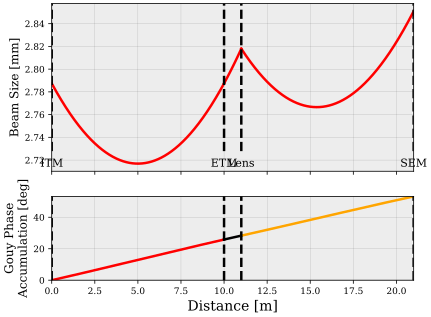

In [10]:
tsy = finesse.tracing.tools.propagate_beam(
    from_node=kat.L0.p1.o, to_node=kat.SEM.p2.o, direction="x"
)

fig, (ax1, ax2)  = tsy.plot()
background_color = '#ededed'

ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

ax2.set_xlabel('Distance [m]', fontsize=14)
ax1.set_ylabel('Beam Size [mm]', fontsize=12)
ax2.set_ylabel('Gouy Phase\nAccumulation [deg]', fontsize=12)

for line in ax1.get_lines()+ax2.get_lines():
    line.set_linewidth(2.5)

fig.set_size_inches(6.5, 5)

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1.set_subplotspec(gs[0])
ax2.set_subplotspec(gs[1])